<a href="https://colab.research.google.com/github/pauljohn99/ML-learnings/blob/main/Copy_of_mouthanotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 282792, done.
remote: Counting objects: 100% (3903/3903), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 282792 (delta 3667), reused 3876 (delta 3663), pack-reused 278889
Receiving objects: 100% (282792/282792), 566.92 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (258786/258786), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/project-9-at-2023-01-19-16-56-043ac6f5/images'
test_dir = '/content/drive/MyDrive/mouth-anotation/testing/images'


class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
          
        # classes: 0 index is reserved for background
        self.classes = [_,'mouth']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
       
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[1]
print(img.shape, '\n',target)

length of dataset =  51 

(224, 224, 3) 
 {'boxes': tensor([[  9.6177,  92.0500, 183.3573, 121.9750]]), 'labels': tensor([1]), 'area': tensor([5199.1572]), 'iscrowd': tensor([0]), 'image_id': tensor([1])}


<class 'matplotlib.patches.Rectangle'>


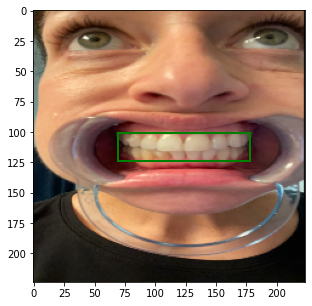

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'g',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        print(type(rect))
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[0]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=False))
print(dataset)
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/9]  eta: 0:01:28  lr: 0.000629  loss: 1.1438 (1.1438)  loss_classifier: 0.9820 (0.9820)  loss_box_reg: 0.0325 (0.0325)  loss_objectness: 0.1115 (0.1115)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 9.7993  data: 0.9231  max mem: 3698
Epoch: [0]  [8/9]  eta: 0:00:01  lr: 0.005000  loss: 0.3415 (0.5222)  loss_classifier: 0.2017 (0.3960)  loss_box_reg: 0.0512 (0.0647)  loss_objectness: 0.0409 (0.0465)  loss_rpn_box_reg: 0.0155 (0.0150)  time: 1.8147  data: 0.1177  max mem: 3964
Epoch: [0] Total time: 0:00:16 (1.8181 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:02  model_time: 0.3222 (0.3222)  evaluator_time: 0.0009 (0.0009)  time: 0.6314  data: 0.3061  max mem: 3964
Test:  [3/4]  eta: 0:00:00  model_time: 0.2308 (0.2143)  evaluator_time: 0.0009 (0.0008)  time: 0.4307  data: 0.2137  max mem: 3964
Test: Total time: 0:00:01 (0.4312 s / it)
Averaged stats: model_time: 0.2308 (0.2143)  evaluator_time: 0.0009 (0.0008)
Accumulating evaluation results...
DONE (t=0.

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
torch.save(model,'mouthanotation-1.pt') 

In [ ]:
# pick one image from the test set
img, target = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  26
real #boxes:  1


EXPECTED OUTPUT
{'boxes': tensor([[129.6399, 210.0000, 403.5457, 275.2500]]), 'labels': tensor([1]), 'area': tensor([17872.3555]), 'iscrowd': tensor([0]), 'image_id': tensor([10])}
<class 'matplotlib.patches.Rectangle'>


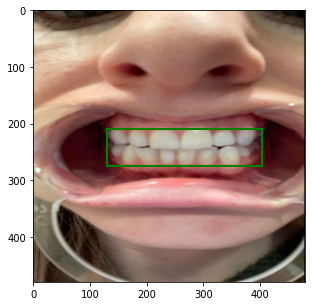

In [ ]:
print('EXPECTED OUTPUT')
print(target)
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT
[[ 97.66802  203.22177  427.72495  259.42355 ]
 [166.33292  216.39601  384.8026   260.80856 ]
 [ 95.04886  215.6541   416.3699   290.25864 ]
 [238.19086  197.59648  416.85538  246.68552 ]
 [126.55574  205.66783  311.00116  255.3528  ]
 [216.07162  200.45908  455.73904  292.78638 ]
 [144.01326  241.08195  360.53186  278.41104 ]
 [236.09305  199.89609  371.83273  278.34613 ]
 [ 21.387287 189.66968  365.62384  281.72424 ]
 [297.58356  191.51408  403.47156  268.5606  ]
 [164.25394  187.86363  478.7689   239.02565 ]
 [145.84477  194.89285  346.09622  240.3218  ]
 [207.79713  227.89757  423.64584  271.7488  ]
 [160.61955  192.57425  261.7165   259.66068 ]
 [229.50598  200.01712  327.25406  258.55728 ]
 [ 48.77483  241.52486  401.2393   305.8189  ]
 [326.6936   183.919    408.99637  247.43076 ]
 [188.11661  197.11497  316.8674   280.645   ]
 [188.38133  173.22986  384.0285   299.21243 ]
 [190.35631  245.9246   407.98657  292.60724 ]
 [ 11.088574 192.49985  398.86087  241.3578  ]


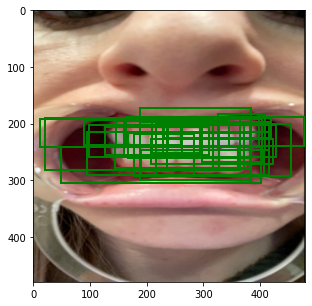

In [ ]:
print('MODEL OUTPUT')
print(prediction['boxes'].detach().cpu().numpy())
pred=prediction['boxes'].detach().cpu()
pred1={'boxes':pred}
# prediction['boxes'].detach().cpu()
# print(prediction['boxes'][1])
print(pred1)
out = torch_to_pil(img)
plot_img_bbox(out,pred1)

{'boxes': tensor([[ 97.6680, 203.2218, 427.7249, 259.4236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6080], device='cuda:0')}
{'boxes': tensor([[ 97.6680, 203.2218, 427.7249, 259.4236]])}
NMS APPLIED MODEL OUTPUT
<class 'matplotlib.patches.Rectangle'>


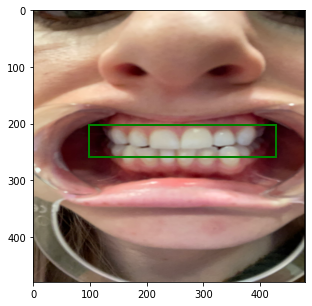

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.1)
print(prediction)
pred=nms_prediction['boxes'].detach().cpu()
pred1={'boxes':pred}
print(pred1)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img),pred1)

{'boxes': tensor([[ 97.6680, 203.2218, 427.7249, 259.4236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6080], device='cuda:0')}
tensor([0.6080], device='cuda:0')
[0.60801774]
0
<class 'numpy.ndarray'>
{'boxes': array([[ 97.66802, 203.22177, 427.72495, 259.42355]], dtype=float32)}
NMS APPLIED MODEL OUTPUT
<class 'matplotlib.patches.Rectangle'>


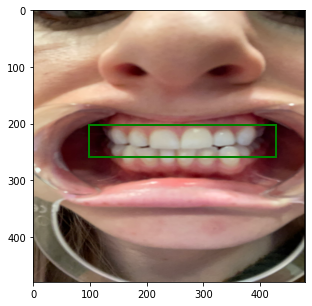

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print(nms_prediction)

print(nms_prediction['scores'])
print(nms_prediction['scores'].detach().cpu().numpy())
p=nms_prediction['scores'].detach().cpu().numpy()
pr=np.argmax(p)
print(pr)
pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
print(type(pred))
pred1={'boxes': pred}
print(pred1)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img),pred1)

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


In [ ]:
device = torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# %%timeit
# img, target = test_dataset[0]

# with torch.no_grad():
#   prediction = model([img.to(device)])[0]
# nms_prediction = apply_nms(prediction, iou_thresh=0.1)

In [ ]:
def areaBound(box,img):
   x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
   area=width*height
   area1=img.size[0]*img.size[1]
   ratio=area/area1
   return(ratio)

In [ ]:

test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set

y=len(test_dataset)
sum=0;
# model.eval()
for i in range(y):
 img, target = test_dataset[i]
 # put the model in evaluation mode
 
 with torch.no_grad():
    prediction = model([img.to(device)])[0]
 i=i+1  
#  print('EXPECTED OUTPUT\n')
#  plot_img_bbox(torch_to_pil(img), target)
 print('MODEL OUTPUT\n')
 nms_prediction = apply_nms(prediction, iou_thresh=0.1)
#  print(nms_prediction['scores'])
#  print(nms_prediction['scores'].detach().cpu().numpy())
 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 x=max(p)
 if x>0.8:
  print('score=',x)
#  print(x)
  pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
# print(type(pred))
  pred4={'boxes': pred}
# print(pred1)
 
  pred=target['boxes'].detach().cpu().numpy()
  pred1=pred[0]

  p=nms_prediction['scores'].detach().cpu().numpy()
  pr=np.argmax(p)
  pred3=nms_prediction['boxes'][pr].detach().cpu().numpy()
 
 
  print('iou=',bb_intersection_over_union(pred1, pred3))
  iou=bb_intersection_over_union(pred1, pred3)
  sum=sum+iou

  image=torch_to_pil(img)
  areaBound(pred3,image)
  print('area',areaBound(pred3,image))

#  print('NMS APPLIED MODEL OUTPUT')
  plot_img_bbox(torch_to_pil(img), pred4)
print('sum=',sum) 
average=sum/y
print('average',average)

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT

MODEL OUTPUT



ValueError: ignored

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
y=len(test_dataset)
sum=0;
for i in range(y):
 img, target = test_dataset[i]
 # put the model in evaluation mode
 model.eval()
 with torch.no_grad():
    prediction = model([img.to(device)])[0]
 i=i+1  
#  print('EXPECTED OUTPUT\n')
#  plot_img_bbox(torch_to_pil(img), target)
 print('MODEL OUTPUT\n')
 nms_prediction = apply_nms(prediction, iou_thresh=0.1)
#  print(nms_prediction['scores'])
#  print(nms_prediction['scores'].detach().cpu().numpy())
 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 x=max(p)
#  print(x)
 pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
# print(type(pred))
 pred4={'boxes': pred}
# print(pred1)
 
 pred=target['boxes'].detach().cpu().numpy()
 pred1=pred[0]

 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 pred3=nms_prediction['boxes'][pr].detach().cpu().numpy()
 
 
 print('iou',bb_intersection_over_union(pred1, pred3))
 iou=bb_intersection_over_union(pred1, pred3)
 sum=sum+iou

 image=torch_to_pil(img)
 areaBound(pred3,image)
 print('area',areaBound(pred3,image))

#  print('NMS APPLIED MODEL OUTPUT')
 plot_img_bbox(torch_to_pil(img), pred4)
print('sum=',sum) 
average=sum/y
print('average',average)

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
y=len(test_dataset)
sum=0;
for i in range(y):
 img, target = test_dataset[i]
 # put the model in evaluation mode
 model.eval()
 with torch.no_grad():
    prediction = model([img.to(device)])[0]
 i=i+1  
#  print('EXPECTED OUTPUT\n')
#  plot_img_bbox(torch_to_pil(img), target)
 print('MODEL OUTPUT\n')
 nms_prediction = apply_nms(prediction, iou_thresh=0.1)
#  print(nms_prediction['scores'])
#  print(nms_prediction['scores'].detach().cpu().numpy())
 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 x=max(p)
#  print(x)
 pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
# print(type(pred))
 pred4={'boxes': pred}
# print(pred1)
 
 pred=target['boxes'].detach().cpu().numpy()
 pred1=pred[0]

 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 pred3=nms_prediction['boxes'][pr].detach().cpu().numpy()
 
 
 print('iou',bb_intersection_over_union(pred1, pred3))
 iou=bb_intersection_over_union(pred1, pred3)
 sum=sum+iou

 image=torch_to_pil(img)
#  areaBound(pred3,image)
 print('area',areaBound(pred3,image))

#  print('NMS APPLIED MODEL OUTPUT')
 plot_img_bbox(torch_to_pil(img), pred4)
print('sum=',sum) 
average=sum/y
print('average',average)

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
y=len(test_dataset)
sum=0;
for i in range(y):
 img, target = test_dataset[i]
 # put the model in evaluation mode
 model.eval()
 with torch.no_grad():
    prediction = model([img.to(device)])[0]
 i=i+1  
#  print('EXPECTED OUTPUT\n')
#  plot_img_bbox(torch_to_pil(img), target)
 print('MODEL OUTPUT\n')
 nms_prediction = apply_nms(prediction, iou_thresh=0.1)
#  print(nms_prediction['scores'])
#  print(nms_prediction['scores'].detach().cpu().numpy())
 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 x=max(p)
#  print(x)
 pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
# print(type(pred))
 pred4={'boxes': pred}
# print(pred1)
 
 pred=target['boxes'].detach().cpu().numpy()
 pred1=pred[0]

 p=nms_prediction['scores'].detach().cpu().numpy()
 pr=np.argmax(p)
 pred3=nms_prediction['boxes'][pr].detach().cpu().numpy()
 
 
 print('iou',bb_intersection_over_union(pred1, pred3))
 iou=bb_intersection_over_union(pred1, pred3)
 sum=sum+iou

 image=torch_to_pil(img)
#  areaBound(pred3,image)
 print('area',areaBound(pred3,image))

#  print('NMS APPLIED MODEL OUTPUT')
 plot_img_bbox(torch_to_pil(img), pred4)
print('sum=',sum) 
average=sum/y
print('average',average)